In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

1. Read Data

In [2]:
test = pd.read_csv('data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [4]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

1.1 Split the year data

In [5]:
train_2013 = train[train['date'] < '2014-01-01']
train_2014 = train[(train['date'] < '2015-01-01') & (train['date'] >= '2014-01-01')]
test_2014 = train[(train['date'] < '2015-01-01') & (train['date'] >= '2014-01-01')]
train_2015 = train[train['date'] >= '2015-01-01']

2. Data cleaning
a. remove the unormal sales data (e.g. sales < 0)

In [6]:
train_2013_monthly = train_2013[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_2013_monthly = train_2013_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_2013_monthly = train_2013_monthly.agg({'item_cnt_day':['sum']})
train_2013_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_2013_monthly = train_2013_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_2013_monthly['item_cnt_month'] = train_2013_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)


In [7]:
train_2014_monthly = train_2014[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_2014_monthly = train_2014_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_2014_monthly = train_2014_monthly.agg({'item_cnt_day':['sum']})
train_2014_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_2014_monthly = train_2014_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_2014_monthly['item_cnt_month'] = train_2014_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# display(train_2014_monthly.head(10).T)
# display(train_2014_monthly.describe().T)

In [8]:
train_2015_monthly = train_2015[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_2015_monthly = train_2015_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_2015_monthly = train_2015_monthly.agg({'item_cnt_day':['sum']})
train_2015_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_2015_monthly = train_2015_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_2015_monthly['item_cnt_month'] = train_2015_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# display(train_2015_monthly.head(10).T)
# display(train_2015_monthly.describe().T)

3. Convert to time series

In [9]:
monthly_2013_series = train_2013_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_2013_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0
2,2,33,1,0,0,0,0,0,0,0,0,0,2,1
3,2,464,0,0,0,1,0,0,1,0,0,2,0,0
4,2,482,1,1,1,1,1,2,1,0,2,1,2,1


In [10]:
monthly_2014_series = train_2014_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_2014_series.head()

date_block_num,shop_id,item_id,12,13,14,15,16,17,18,19,20,21,22,23
0,2,30,0,0,0,1,1,0,0,0,0,0,0,0
1,2,31,0,0,0,0,1,0,0,0,0,0,0,0
2,2,32,1,0,1,0,0,0,1,0,2,2,0,2
3,2,33,1,0,0,0,0,0,0,0,1,0,0,0
4,2,76,0,0,0,0,0,1,0,0,0,0,0,0


In [11]:
monthly_2015_series = train_2015_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_2015_series.head()

date_block_num,shop_id,item_id,24,25,26,27,28,29,30,31,32,33
0,2,31,0,0,0,0,0,0,0,0,0,1
1,2,32,0,0,1,0,0,0,0,1,0,0
2,2,33,0,1,0,1,1,0,1,0,1,0
3,2,53,0,1,0,0,0,0,0,0,0,0
4,2,59,0,1,0,0,0,0,0,0,0,0


4. Assigning label for each pair of (shop_id, item_id)

In [12]:
data_series = []
for index, row in monthly_2013_series.iterrows():
    # if i in range(50):
    #     print(row[11])
    #     i+=1
    serie = [row['shop_id'], row['item_id']]
    for i in range(12):
        serie.append(row[i])
    serie.append(row[11])
    data_series.append(serie)


columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(12)]
columns.append('label')

data_2013_series = pd.DataFrame(data_series, columns=columns)
data_2013_series.head(10)


,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0,0
2,2,33,1,0,0,0,0,0,0,0,0,0,2,1,1
3,2,464,0,0,0,1,0,0,1,0,0,2,0,0,0
4,2,482,1,1,1,1,1,2,1,0,2,1,2,1,1
5,2,491,1,0,0,0,1,2,0,1,0,0,0,0,0
6,2,496,0,1,0,0,0,0,0,0,0,0,0,0,0
7,2,638,0,0,0,0,0,0,1,0,0,0,0,0,0
8,2,687,0,0,1,0,1,0,0,0,0,0,0,0,0
9,2,790,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
data_series = []
for index, row in monthly_2014_series.iterrows():
    # if i in range(50):
    #     print(row[11])
    #     i+=1
    serie = [row['shop_id'], row['item_id']]
    for i in range(12,24):
        serie.append(row[i])
    serie.append(row[23])
    data_series.append(serie)


columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(12)]
columns.append('label')

data_2014_series = pd.DataFrame(data_series, columns=columns)
data_2014_series.head(10)

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,1,1,0,0,0,0,0,0,0,0
1,2,31,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,32,1,0,1,0,0,0,1,0,2,2,0,2,2
3,2,33,1,0,0,0,0,0,0,0,1,0,0,0,0
4,2,76,0,0,0,0,0,1,0,0,0,0,0,0,0
5,2,464,0,0,0,0,0,0,0,0,0,1,0,0,0
6,2,482,2,1,0,0,0,0,1,0,2,1,0,0,0
7,2,486,0,0,0,0,0,0,0,0,1,1,2,0,0
8,2,491,0,0,0,0,1,0,1,0,0,1,1,0,0
9,2,496,0,0,0,0,1,0,0,0,0,0,0,0,0


In [14]:

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(10)]
columns.append('label')
columns

['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'label']

In [ ]:
# data_series = []
# for index, row in monthly_2015_series.iterrows():
#     # if i in range(50):
#     #     print(row[11])
#     #     i+=1
#     serie = [row['shop_id'], row['item_id']]
#     for i in range(24,34):
#         serie.append(row[i])
#     serie.append(row[33])
#     data_series.append(serie)


# columns = ['shop_id', 'item_id']
# [columns.append(i) for i in range(10)]
# columns.append('label')

# data_2015_series = pd.DataFrame(data_series, columns=columns)
# data_2015_series.head(10)

In [15]:
data_2013_series = data_2013_series.drop(['item_id', 'shop_id'], axis=1)
data_2014_series = data_2014_series.drop(['item_id', 'shop_id'], axis=1)

In [16]:
labels_2013 = data_2013_series['label']
labels_2014 = data_2014_series['label']
data_2013_series.drop('label', axis=1, inplace=True)
data_2014_series.drop('label', axis=1, inplace=True)

4.1 Build up input data of model

In [17]:
# train 2013 (If train 2014, then change the series to data_2014_series and label_2014)
train, valid, Y_train, Y_valid = train_test_split(data_2013_series, labels_2013.values, test_size=0.10, random_state=0)

In [18]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (31079, 12, 1)
Validation set reshaped (3454, 12, 1)


5. Build up model

In [20]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

def lstm_model_beta():
    
    lstm_beta = Sequential() 
    lstm_beta.add(LSTM(128, input_shape=(serie_size, n_features)))
    lstm_beta.add(Dense(128, activation='softmax'))
    lstm_beta.add(Dense(64, activation='softmax'))
    lstm_beta.add(Dense(1)) 

    # define the loss function / optimization strategy, and fit
    # adam = optimizers.Adam(lr)
    # the model with the desired number of passes over the data (epochs) 
    lstm_beta.compile(loss='mse', optimizer='adam')
    return lstm_beta

lstm_beta = lstm_model_beta()

5.1 Model training

In [40]:
lstm_beta_fit = lstm_beta.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/30


2022-04-23 19:23:51.250465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-23 19:23:51.392630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-23 19:23:51.476284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-23 19:23:57.234317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-23 19:23:57.281618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


455/455 - 7s - loss: 5.8135 - val_loss: 5.2493 - 7s/epoch - 15ms/step
Epoch 2/30
455/455 - 5s - loss: 5.2443 - val_loss: 5.1426 - 5s/epoch - 12ms/step
Epoch 3/30
455/455 - 5s - loss: 5.1986 - val_loss: 5.1376 - 5s/epoch - 12ms/step
Epoch 4/30
455/455 - 6s - loss: 4.9619 - val_loss: 4.2483 - 6s/epoch - 12ms/step
Epoch 5/30
455/455 - 6s - loss: 3.6006 - val_loss: 3.0392 - 6s/epoch - 12ms/step
Epoch 6/30
455/455 - 6s - loss: 2.5916 - val_loss: 2.1735 - 6s/epoch - 12ms/step
Epoch 7/30
455/455 - 5s - loss: 1.8621 - val_loss: 1.6347 - 5s/epoch - 12ms/step
Epoch 8/30
455/455 - 5s - loss: 1.4288 - val_loss: 1.3037 - 5s/epoch - 12ms/step
Epoch 9/30
455/455 - 5s - loss: 1.1555 - val_loss: 1.0998 - 5s/epoch - 12ms/step
Epoch 10/30
455/455 - 5s - loss: 0.9601 - val_loss: 0.9075 - 5s/epoch - 12ms/step
Epoch 11/30
455/455 - 6s - loss: 0.8255 - val_loss: 0.8131 - 6s/epoch - 12ms/step
Epoch 12/30
455/455 - 5s - loss: 0.7470 - val_loss: 0.7327 - 5s/epoch - 12ms/step
Epoch 13/30
455/455 - 6s - loss: 0.6

5.2 Model fitting evaluation

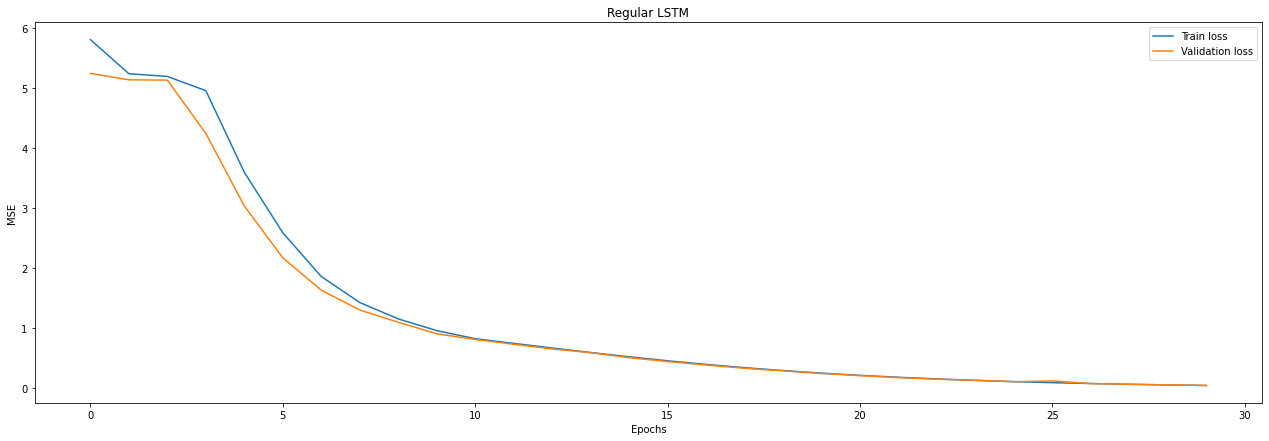

In [41]:
fig, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(22,7))

ax1.plot(lstm_beta_fit.history['loss'], label='Train loss')
ax1.plot(lstm_beta_fit.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.savefig('./loss.jpg')
plt.show()

In [42]:
lstm_train_pred = lstm_beta.predict(X_train)
lstm_val_pred = lstm_beta.predict(X_valid)
print('Regular lstm model:')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

2022-04-23 19:35:38.775747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-23 19:35:38.824337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Regular lstm model:
Train rmse: 0.2019260093634699
Validation rmse: 0.21143488849385933


6. Prediction

In [30]:
# predict 2014, if 2015, then change the series name '_2014_' to '_2015_'
latest_records = monthly_2014_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
# X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test.head()

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [31]:
lstm_test_pred = lstm_beta.predict(X_test_reshaped)

2022-04-23 17:42:59.483443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-23 17:42:59.519397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [32]:
lstm_pred = pd.DataFrame(test['ID'], columns=['ID'])
lstm_pred['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
# lstm_pred.to_csv('./regular_lstm_pred.csv', index=False)
lstm_pred.head(10)

,ID,item_cnt_month
0,0,1.96
1,1,0.01
2,2,0.01
3,3,0.01
4,4,0.01
5,5,2.92
6,6,0.01
7,7,4.91
8,8,0.01
9,9,0.01


In [33]:
pred = lstm_pred
pred['shop_id'] = test['shop_id']
pred['item_id'] = test['item_id']

In [34]:
result = pred.join(items, on='item_id',how='left', lsuffix='_left', rsuffix='_right')
result.head()

,ID,item_cnt_month,shop_id,item_id_left,item_name,item_id_right,item_category_id
0,0,1.96,5,5037,"NHL 15 [PS3, русские субтитры]",5037,19
1,1,0.01,5,5320,ONE DIRECTION Made In The A.M.,5320,55
2,2,0.01,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",5233,19
3,3,0.01,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",5232,23
4,4,0.01,5,5268,"Need for Speed [PS4, русская версия]",5268,20


In [35]:
result = result.drop(['item_name','item_id_left','item_id_right'],axis=1)

In [36]:
result.to_csv('./result_2014.csv')
# If predict 2015, change it to result.to_csv('./result_2015.csv')